## Import Libaries
- 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from random import sample, randint

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
import easyocr

from lxml import etree

from alpr_lib.image import ImageData
from alpr_lib.transform import ImageTransformation

## Chargement du Dataset (Load Dataset)
Le Dataset contient 
- Les annotations sont des fichiers xml, qui contient les coordonnées des regions intérêt sur les images (les étiquettes) 
- Les differentes images des plaques d'immatriculations


In [2]:
#parcourir les fichiers images et dataset
src_path = "dataset/input"
for dirName, _, fileNames in os.walk('dataset/input'):
    for fileName in fileNames:
        print(os.path.join(dirName, fileName))

dataset/input\annotations\Cars0.xml
dataset/input\annotations\Cars1.xml
dataset/input\annotations\Cars10.xml
dataset/input\annotations\Cars100.xml
dataset/input\annotations\Cars101.xml
dataset/input\annotations\Cars102.xml
dataset/input\annotations\Cars103.xml
dataset/input\annotations\Cars104.xml
dataset/input\annotations\Cars105.xml
dataset/input\annotations\Cars106.xml
dataset/input\annotations\Cars107.xml
dataset/input\annotations\Cars108.xml
dataset/input\annotations\Cars109.xml
dataset/input\annotations\Cars11.xml
dataset/input\annotations\Cars110.xml
dataset/input\annotations\Cars111.xml
dataset/input\annotations\Cars112.xml
dataset/input\annotations\Cars113.xml
dataset/input\annotations\Cars114.xml
dataset/input\annotations\Cars115.xml
dataset/input\annotations\Cars116.xml
dataset/input\annotations\Cars117.xml
dataset/input\annotations\Cars118.xml
dataset/input\annotations\Cars119.xml
dataset/input\annotations\Cars12.xml
dataset/input\annotations\Cars120.xml
dataset/input\annot

## Extraction
Extraire les informations
- Les images seront stocker dans une liste `X` 
- Les coordonnées seront extrait des annotations (étiquettes) et stocker dans un vecteur `y = [vx,vy]`

|  vx  |  vy  |
|------|------|
| xmin | ymin |
| xmax | ymax | 


#### Extraction d'images

In [3]:
# Définir taille d'image 
IMAGE_SIZE = 200

img_dir = src_path + "/images" ##"../input/car-plate-detection/images"
data_path = os.path.join(img_dir,'*g') # all files end with ...g (png, jpg, )
files = glob.glob(data_path)
files.sort()

images_data = []

X=[] # List des
for path in files:
    img = cv2.imread(path)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    images_data.append(ImageData(path=path, pixel=img))

In [4]:
# nombre d'image
print(len(images_data))

433


#### Extraction des coordonnées (dans les annotations)

In [5]:
def resizeannotation(f):  # Fonction qui va extraire les informations des fichiers xml
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width / IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text) / (height / IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text) / (width / IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text) / (height / IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [6]:
path = src_path + '/annotations'
text_files = [path +'/'+f for f in sorted(os.listdir(path))] # Stocker les fichiers xml dans la liste

y=[] # List des coordonnées des regions intérêt
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
#for img in text_files: print(img)
#for img in X: print(img)

## Afficher les images du dataset (Display Image Dataset)

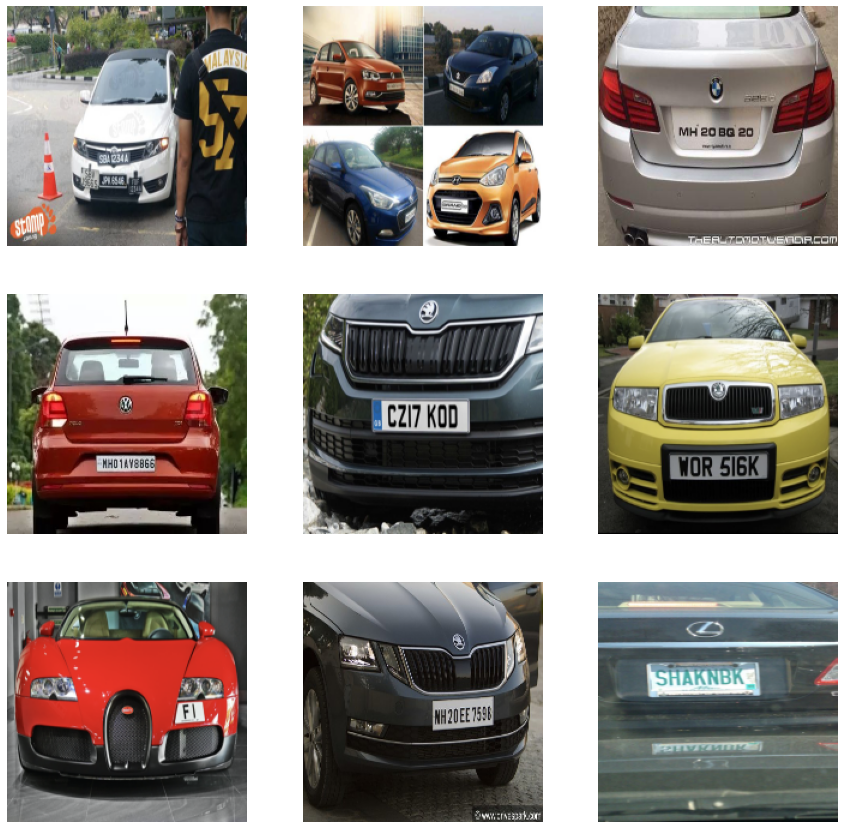

In [8]:
sample_index = []

for i in range(9):
    sample_index.append(i+8)

plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))

## Verifier la taille des images

In [9]:
print(f"X Shape : {np.array(X).shape}")
print(f"y Shape : {np.array(y).shape}")

X Shape : (433, 200, 200, 3)
y Shape : (433, 4)


## Afficher les images du dataset avec leurs annotations (région d'interêt) 

In [13]:
def crop(img_path, resize, show = True , write=False):
    plt.figure(figsize=(15, 15))
    xy = resize
    img = img_path #cv2.imread(img_path)
    print(f"image original shape : {img.shape}") # Print image shape
    #plt.imshow(img)

        # Cropping an image
        # cropped = img[start_row:end_row, start_col:end_col]
    cropped_image = img[xy[0]:xy[1], xy[2]:xy[3]]
    #print(f"cropped shape : {cropped_image.shape}")
    print(f"image cropped shape : {cropped_image.shape}")
  
    if(show):
        # Display cropped image
        plt.imshow(cropped_image)
        #print(f"cropped shape : {cropped_image.shape}")
    if(write):
        # Save the cropped image
        cv2.imwrite("Cropped_Image.jpg", cropped_image)

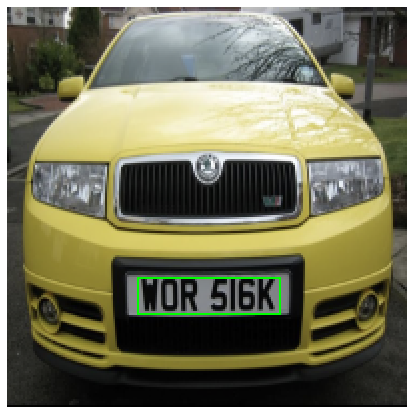

In [14]:
test_index = [13]

plt.figure(figsize=(25, 25))
for index, i in enumerate(test_index):
    plt.subplot(3, 3, index + 1)
    image = cv2.rectangle(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB),(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 255, 0), 1)
    plt.imshow(image)
    plt.axis("off")
    break

plt.show()

In [15]:
rnd = 13

image original shape : (200, 200, 3)
image cropped shape : (17, 70, 3)


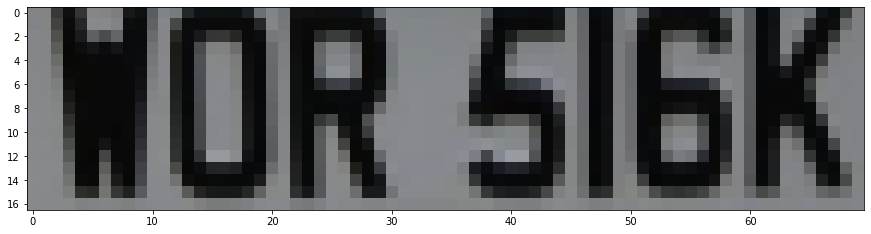

In [16]:
crop(cv2.cvtColor(X[rnd], cv2.COLOR_BGR2RGB),resize=y[rnd], write=True)

In [17]:
reader = easyocr.Reader(['en','fr'],gpu=False) 
result = reader.readtext('Cropped_Image.jpg', detail = 0)
result[0][1]

Using CPU. Note: This module is much faster with a GPU.


['WOR 516K']